# INICIALIZACIÓN

In [ ]:
!pip install keras-tuner

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib

#SVR & RF
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#ANNs
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Flatten
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping
import kerastuner as kt


#semilla para poder replicar
semilla = 42
np.random.seed(semilla)
os.environ['PYTHONHASHSEED'] = str(semilla)
tf.random.set_seed(semilla)

In [7]:
train = pd.read_csv("/content/train.csv")
train.dropna(inplace=True)
test = pd.read_csv("/content/test.csv")
test.dropna(inplace=True)

pd.set_option('display.max_columns', None)
train.head(7)

,kW Total,Ss-MT,Recalentamiento BT,Pc,Tc-BT,Trec,Sd-BT,Sd-MT,Prec (Recipiente),Po-MT,Ss-IT,Ss-BT,% Apertura Vhp,Running capacity LT,Running capacity IT,Suction temp. To-MT,% Apert.Vrec (Recip),Condenser speed 1,Rec. low liquid leve,Tc Error,Day_sin,Day_cos,Week_sin,Week_cos,M.Frutas,M.4,M.Pescado,M.Refrig,M.Carne,M.Charcuteria,V.Carne,V.Charcuteria,V.Charc/quesos,Cam.Frutas,Prep.Frutas,Cam.Basura,Prep.Pescado,Cam.Pescado,Cam.Pollos,Cam.Lacteos,Antecamara,Cam.Carnes,Prep.Carnes,Cam.Aves,Cam.Empacados,Cam.Quesos,Cam.Charcuteria,Prep.Charcuteria,M.Arm.Cong.,Arm.Cong.,Bandeja,Cava,C.Congelados
11,24.730769,8.43,30.66,58.84,-8.00,0.38,78.63,64.36,33.65,26.54,22.37,-3.10,6.92,72.0,0.0,-7.99,3.32,23.42,0,0,0.486526,0.873666,-0.498082,-0.867130,-1.883532,-0.475416,-1.878883,-4.943881,0.726755,-9.391805,-1.034726,-1.473581,3.442105,-0.213964,2.993175,-0.179103,-0.413164,-1.260069,3.750056,-2.963853,-2.709391,-1.214679,-0.377032,9.818723,0.016091,0.558860,0.662755,0.954101,-1.232373,-0.382899,6.671724,-0.415206,2.339428
12,25.437179,8.19,30.75,58.67,-7.63,0.28,76.30,72.57,33.55,26.90,22.31,-2.22,9.54,91.8,0.0,-7.61,7.74,26.90,0,0,0.524172,0.851613,-0.503478,-0.864008,-2.384803,-1.875842,-0.639865,-1.968103,-0.037204,-2.172526,0.729299,1.451825,-0.814006,-0.148260,2.915453,-0.079791,-0.726602,-0.954140,1.585365,-1.715510,-0.998449,0.009567,-0.887660,10.557044,-0.196900,1.787793,1.417525,0.548661,-2.135403,0.100293,14.785223,0.542729,1.201820
13,24.751282,8.54,31.12,58.20,-8.68,0.07,76.58,74.18,33.33,25.89,22.30,-3.18,7.54,91.2,0.0,-8.77,6.38,23.78,0,0,0.560820,0.827938,-0.508854,-0.860853,-1.927374,-0.897911,-3.526544,-13.159167,-1.807366,2.502902,-0.577846,0.886811,3.773995,-1.126395,2.697242,-1.566837,-1.538782,-0.106251,1.099985,-0.329045,0.210804,0.774841,-1.761969,9.973952,-0.584030,3.236354,2.465206,-0.443709,-2.019735,-1.025661,13.401982,-0.429066,-0.706502
14,25.256410,8.60,30.46,59.37,-7.13,0.40,78.25,65.43,33.69,27.00,22.23,-2.77,7.96,95.8,0.0,-7.22,6.08,24.54,0,0,0.596400,0.802687,-0.514210,-0.857665,-1.466436,0.084376,-0.557014,2.487689,0.521661,-0.013288,-0.492880,-0.994384,-0.275331,-1.417018,2.762397,-0.589710,-1.157201,1.884803,-1.374166,0.282512,-2.305335,-0.489733,-1.253992,9.808660,-0.346082,3.126209,2.093256,0.074112,-2.857318,-0.299134,14.716249,-0.689397,-1.600660
15,25.916667,8.16,29.87,58.70,-7.66,0.31,77.42,62.87,33.59,26.85,22.22,-4.01,10.08,95.8,0.0,-7.65,8.14,26.92,0,0,0.630845,0.775909,-0.519546,-0.854443,-3.574581,-1.751180,0.772608,3.484256,0.805854,-0.591505,0.605843,2.114602,-6.499659,-0.956084,2.915453,0.513203,-0.455362,1.594877,-1.632230,0.511959,-1.610294,-1.044051,-0.730803,6.944866,-0.132091,2.981013,-2.052870,0.555301,-2.587607,-2.653813,12.599527,-0.833835,-1.755658
16,24.943590,7.49,29.25,57.24,-8.71,0.22,77.07,58.58,33.47,26.21,22.29,-5.91,6.66,76.6,0.0,-8.78,6.16,22.70,0,0,0.664089,0.747653,-0.524862,-0.851188,-1.339343,-1.055845,-1.548342,-6.712749,-0.843897,2.349220,-0.970318,-0.920044,-4.304217,-0.306170,2.949354,-0.690466,-0.484483,-0.829381,-2.090389,1.680519,-0.081933,-0.261166,-1.894824,10.242050,-0.648838,2.850231,-0.962410,-0.690320,-2.641531,-8.295670,18.752745,-1.739580,-1.978683
17,25.067949,10.21,29.37,58.86,-7.48,0.23,73.75,52.28,33.54,26.97,22.20,-3.18,9.22,81.6,0.0,-7.50,4.98,21.88,0,0,0.696069,0.717974,-0.530157,-0.847899,-1.587474,0.364364,-0.750423,2.275467,0.018999,0.018173,0.328731,0.628567,0.880934,0.101146,2.872164,0.506198,-0.751336,-1.013469,-1.010957,1.730832,0.530706,0.568753,-0.454618,10.069272,0.035949,-1.698919,-0.756713,0.868763,-3.021048,-5.424373,12.242137,-1.052823,-0.802244


Seleccionamos las variables.

In [ ]:
#elegimos las columnas a transformar y la variable objetivo (target)
cols = ['Pc', '% Apertura Vhp', 'Sd-MT', 'Running capacity IT','Week_cos', 'M.Refrig', 'Day_cos'] #sin Cam.Aves ni Bandeja
target = 'kW Total'

# Support Vector Regression (SVR)

Primero creamos los rezagos o lags en el conjunto de datos.

In [ ]:
def crear_lags(df, n_lags, cols):
    df_con_lags = pd.DataFrame(index=df.index)
    for col in cols:
        #creamos n columnas con el valor retrasado de la columna
        for lag in range(1, n_lags + 1):
            col_lag = f"{col}_lag{lag}"
            df_con_lags[col_lag] = df[col].shift(lag)


    #añadimos el valor actual de kW Total
    df_con_lags['kW Total'] = df['kW Total']
    df_con_lags=df_con_lags.dropna()

    return df_con_lags

In [ ]:
n_lags = 6
train_transformado = crear_lags(train, n_lags, cols)
test_transformado = crear_lags(test, n_lags, cols)

train_transformado.head(5)

,Pc_lag1,Pc_lag2,Pc_lag3,Pc_lag4,Pc_lag5,Pc_lag6,% Apertura Vhp_lag1,% Apertura Vhp_lag2,% Apertura Vhp_lag3,% Apertura Vhp_lag4,% Apertura Vhp_lag5,% Apertura Vhp_lag6,Sd-MT_lag1,Sd-MT_lag2,Sd-MT_lag3,Sd-MT_lag4,Sd-MT_lag5,Sd-MT_lag6,Running capacity IT_lag1,Running capacity IT_lag2,Running capacity IT_lag3,Running capacity IT_lag4,Running capacity IT_lag5,Running capacity IT_lag6,Week_cos_lag1,Week_cos_lag2,Week_cos_lag3,Week_cos_lag4,Week_cos_lag5,Week_cos_lag6,M.Refrig_lag1,M.Refrig_lag2,M.Refrig_lag3,M.Refrig_lag4,M.Refrig_lag5,M.Refrig_lag6,Day_cos_lag1,Day_cos_lag2,Day_cos_lag3,Day_cos_lag4,Day_cos_lag5,Day_cos_lag6,kW Total
17,57.24,58.70,59.37,58.20,58.67,58.84,6.66,10.08,7.96,7.54,9.54,6.92,58.58,62.87,65.43,74.18,72.57,64.36,0.0,0.0,0.0,0.0,0.0,0.0,-0.851188,-0.854443,-0.857665,-0.860853,-0.864008,-0.867130,-6.712749,3.484256,2.487689,-13.159167,-1.968103,-4.943881,0.747653,0.775909,0.802687,0.827938,0.851613,0.873666,25.067949
18,58.86,57.24,58.70,59.37,58.20,58.67,9.22,6.66,10.08,7.96,7.54,9.54,52.28,58.58,62.87,65.43,74.18,72.57,0.0,0.0,0.0,0.0,0.0,0.0,-0.847899,-0.851188,-0.854443,-0.857665,-0.860853,-0.864008,2.275467,-6.712749,3.484256,2.487689,-13.159167,-1.968103,0.717974,0.747653,0.775909,0.802687,0.827938,0.851613,25.412821
19,58.66,58.86,57.24,58.70,59.37,58.20,8.94,9.22,6.66,10.08,7.96,7.54,58.82,52.28,58.58,62.87,65.43,74.18,0.0,0.0,0.0,0.0,0.0,0.0,-0.844578,-0.847899,-0.851188,-0.854443,-0.857665,-0.860853,2.187940,2.275467,-6.712749,3.484256,2.487689,-13.159167,0.686929,0.717974,0.747653,0.775909,0.802687,0.827938,25.773077
20,58.46,58.66,58.86,57.24,58.70,59.37,9.34,8.94,9.22,6.66,10.08,7.96,59.07,58.82,52.28,58.58,62.87,65.43,0.0,0.0,0.0,0.0,0.0,0.0,-0.841224,-0.844578,-0.847899,-0.851188,-0.854443,-0.857665,-3.863161,2.187940,2.275467,-6.712749,3.484256,2.487689,0.654576,0.686929,0.717974,0.747653,0.775909,0.802687,25.730769
21,58.42,58.46,58.66,58.86,57.24,58.70,8.96,9.34,8.94,9.22,6.66,10.08,58.72,59.07,58.82,52.28,58.58,62.87,0.0,0.0,0.0,0.0,0.0,0.0,-0.837838,-0.841224,-0.844578,-0.847899,-0.851188,-0.854443,-7.832126,-3.863161,2.187940,2.275467,-6.712749,3.484256,0.620977,0.654576,0.686929,0.717974,0.747653,0.775909,26.129487


División de variables independientes y objetivo.

In [ ]:
X_train = train_transformado.drop(columns='kW Total').values
y_train = train_transformado['kW Total'].values

X_test = test_transformado.drop(columns='kW Total').values
y_test = test_transformado['kW Total'].values

Estandarizamos las variables independientes.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Entrenamos el modelo SVR con diferentes hiperparámetros (Grid Search)

In [ ]:
#espacio de hiperparámetros a probar
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'gamma': [0.0001, 0.001, 0.01, 0.1]
}

#validación cruzada para series temporales
tscv = TimeSeriesSplit(n_splits=5)

#valores iniciales
best_score = float('inf')
best_params = None

inicio=0
fin=len(param_grid['C'])*len(param_grid['gamma'])

#iteramos sobre todas las combinaciones de hiperparámetros posibles
for C in param_grid['C']:
    for gamma in param_grid['gamma']:
      inicio+=1
      svr = SVR(kernel='rbf', C=C, gamma=gamma)
      scores = []

      #validación cruzada
      for train_index, test_index in tscv.split(X_train_scaled):
          X_train_fold, X_test_fold = X_train_scaled[train_index], X_train_scaled[test_index]
          y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

          svr.fit(X_train_fold, y_train_fold)
          y_pred = svr.predict(X_test_fold)

          mse = mean_squared_error(y_test_fold, y_pred)
          scores.append(mse)

      mean_score = np.mean(scores)

      #imprimimos los resultados 
      print(f"Modelo {inicio}/{fin} --> C: {C}, gamma: {gamma}, MSE: {mean_score:.4f}")

      #guardar el mejor modelo
      if mean_score < best_score:
          best_score = mean_score
          best_params = {'C': C, 'gamma': gamma}
          best_model = svr
#guardar archivo del modelo
joblib.dump(best_model, 'svr_model.joblib')

print("\nMejores hiperparámetros encontrados:")
print(best_params)

Modelo 1/16 --> C: 0.01, gamma: 0.0001, MSE: 32.7766
Modelo 2/16 --> C: 0.01, gamma: 0.001, MSE: 17.8389
Modelo 3/16 --> C: 0.01, gamma: 0.01, MSE: 15.9545
Modelo 4/16 --> C: 0.01, gamma: 0.1, MSE: 29.2947
Modelo 5/16 --> C: 0.1, gamma: 0.0001, MSE: 16.2084
Modelo 6/16 --> C: 0.1, gamma: 0.001, MSE: 11.8929
Modelo 7/16 --> C: 0.1, gamma: 0.01, MSE: 16.1297
Modelo 8/16 --> C: 0.1, gamma: 0.1, MSE: 22.2799
Modelo 9/16 --> C: 1, gamma: 0.0001, MSE: 11.2638
Modelo 10/16 --> C: 1, gamma: 0.001, MSE: 14.2176
Modelo 11/16 --> C: 1, gamma: 0.01, MSE: 15.6525
Modelo 12/16 --> C: 1, gamma: 0.1, MSE: 19.3902
Modelo 13/16 --> C: 10, gamma: 0.0001, MSE: 14.0363
Modelo 14/16 --> C: 10, gamma: 0.001, MSE: 14.0291
Modelo 15/16 --> C: 10, gamma: 0.01, MSE: 15.3222
Modelo 16/16 --> C: 10, gamma: 0.1, MSE: 20.2503

Mejores hiperparámetros encontrados:
{'C': 1, 'gamma': 0.0001}


Calculamos diferentes métricas.

In [ ]:
#predicciones
y_pred = best_model.predict(X_test_scaled)

#raíz de la fracción absoluta de la varianza (R)
def raiz_fraccion_absoluta_varianza(y_true, y_pred):
    numerator = np.sqrt(np.mean(np.abs(y_true - y_pred)))
    denominator = np.sqrt(np.mean(np.abs(y_true - np.mean(y_true))))
    return numerator / denominator
R = raiz_fraccion_absoluta_varianza(y_test, y_pred)

#MSE
mse = mean_squared_error(y_test, y_pred)

#MAE
mae = mean_absolute_error(y_test, y_pred)

#R^2
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")
print(f"R: {R}")

MSE: 2.2767141257372745
MAE: 1.1705291453803948
R2: 0.7825280167396017
R: 0.6695034463412263


Visualizamos la serie con los valores reales, las predicciones y el error

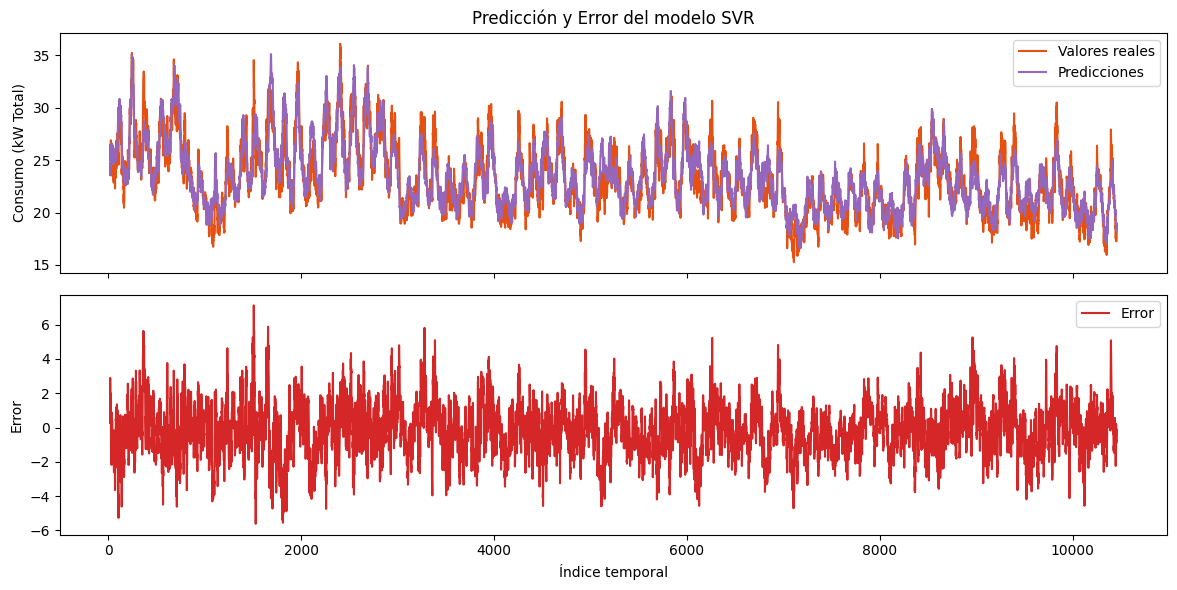

In [ ]:
#resíduos
error = y_test - y_pred

#figura
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)  

#gráfico de valores reales vs predicciones
ax1.plot(test_transformado.index, y_test, label='Valores reales', color='#E65113')
ax1.plot(test_transformado.index, y_pred, label='Predicciones', color="tab:purple")
ax1.set_ylabel('Consumo (kW Total)')
ax1.set_title('Valores reales del consumo vs Predicción con SVR')
ax1.legend()

#gráfico del error
ax2.plot(test_transformado.index, error, color='tab:red', label='Error')
ax1.set_title('Predicción y Error del modelo SVR')
ax2.set_xlabel('Índice temporal')  
ax2.set_ylabel('Error')
ax2.legend()

plt.tight_layout()

plt.show()

Histograma de los resíduos

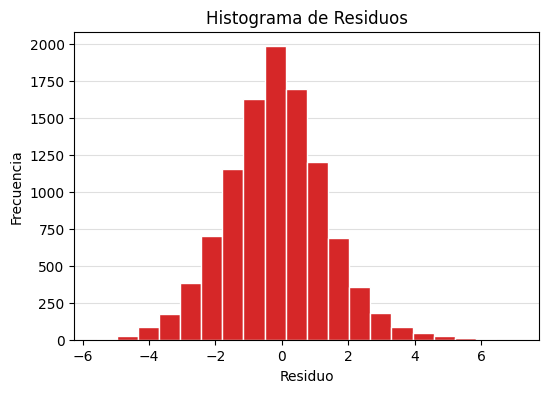

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(error, bins=20, color='tab:red', edgecolor='white')
plt.title('Histograma de Residuos')
plt.xlabel('Residuo')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.4)
plt.gca().set_axisbelow(True)
plt.show()

# Random Forest Regressor (RFR)

In [ ]:
n_lags = 6
train_transformado = crear_lags(train, n_lags, cols)
test_transformado = crear_lags(test, n_lags, cols)

train_transformado.head(2)

,Pc_lag1,Pc_lag2,Pc_lag3,Pc_lag4,Pc_lag5,Pc_lag6,% Apertura Vhp_lag1,% Apertura Vhp_lag2,% Apertura Vhp_lag3,% Apertura Vhp_lag4,% Apertura Vhp_lag5,% Apertura Vhp_lag6,Sd-MT_lag1,Sd-MT_lag2,Sd-MT_lag3,Sd-MT_lag4,Sd-MT_lag5,Sd-MT_lag6,Running capacity IT_lag1,Running capacity IT_lag2,Running capacity IT_lag3,Running capacity IT_lag4,Running capacity IT_lag5,Running capacity IT_lag6,Week_cos_lag1,Week_cos_lag2,Week_cos_lag3,Week_cos_lag4,Week_cos_lag5,Week_cos_lag6,M.Refrig_lag1,M.Refrig_lag2,M.Refrig_lag3,M.Refrig_lag4,M.Refrig_lag5,M.Refrig_lag6,Day_cos_lag1,Day_cos_lag2,Day_cos_lag3,Day_cos_lag4,Day_cos_lag5,Day_cos_lag6,kW Total
11,58.84,58.84,58.84,58.84,58.84,58.84,6.92,6.92,6.92,6.92,6.92,6.92,64.36,64.36,64.36,64.36,64.36,64.36,0.0,0.0,0.0,0.0,0.0,0.0,-0.86713,-0.867130,-0.867130,-0.867130,-0.867130,-0.867130,-4.943881,-4.943881,-4.943881,-4.943881,-4.943881,-4.943881,0.873666,0.873666,0.873666,0.873666,0.873666,0.873666,24.730769
12,58.84,58.67,58.67,58.67,58.67,58.67,6.92,9.54,9.54,9.54,9.54,9.54,64.36,72.57,72.57,72.57,72.57,72.57,0.0,0.0,0.0,0.0,0.0,0.0,-0.86713,-0.864008,-0.864008,-0.864008,-0.864008,-0.864008,-4.943881,-1.968103,-1.968103,-1.968103,-1.968103,-1.968103,0.873666,0.851613,0.851613,0.851613,0.851613,0.851613,25.437179


Dividimos los conjuntos en variables independientes y objetivo.

In [ ]:
X_train = train_transformado.drop(columns='kW Total').values
y_train = train_transformado['kW Total'].values

X_test = test_transformado.drop(columns='kW Total').values
y_test = test_transformado['kW Total'].values

Estandarizamos las vaiables independientes

In [ ]:
#no es necesario pero puede venir bien
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Buscamos el mejor modelo RFR definiendo un espacio de valores para los hiperparámetros y combinando estos hasta 25 iteraciones. Nos quedamos con el modelo más optimo.

In [ ]:
#espacio de búsqueda de hiperparámetros
param_dist = {
    'n_estimators': [25, 50, 75, 100, 150],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

#para validación cruzada 
tscv = TimeSeriesSplit(n_splits=5)

#nº de iteraciones
n_iter = 25

#valores iniciales
best_score = float('inf')
best_params = None

#RandomSearch
for i in range(n_iter):
    params = {
        'n_estimators': random.choice(param_dist['n_estimators']),
        'max_depth': random.choice(param_dist['max_depth']),
        'min_samples_split': random.choice(param_dist['min_samples_split']),
        'min_samples_leaf': random.choice(param_dist['min_samples_leaf'])
    }

    #crear el modelo 
    rf = RandomForestRegressor(**params, random_state=semilla+i)

    scores = []

    #validación cruzada 
    for train_index, test_index in tscv.split(X_train_scaled):
        X_train_fold, X_test_fold = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        rf.fit(X_train_fold, y_train_fold)
        y_pred = rf.predict(X_test_fold)

        mse = mean_squared_error(y_test_fold, y_pred)
        scores.append(mse)

    mean_score = np.mean(scores)
    print(f"Iteración {i+1}/{n_iter}: {params}, MSE: {mean_score:.4f}")

    #guardar mejor modelo
    if mean_score < best_score:
        best_score = mean_score
        best_params = params
        best_model = rf

#guardar archivo del modelo
joblib.dump(best_model, 'best_model_rf.joblib')
print("\nMejores hiperparámetros encontrados:")
print(best_params)


Iteración 1/25: {'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 10}, MSE: 14.9541
Iteración 2/25: {'n_estimators': 25, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 10}, MSE: 15.1318
Iteración 3/25: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}, MSE: 15.0418
Iteración 4/25: {'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 10}, MSE: 14.9691
Iteración 5/25: {'n_estimators': 25, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 10}, MSE: 14.9661
Iteración 6/25: {'n_estimators': 150, 'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 5}, MSE: 14.8805
Iteración 7/25: {'n_estimators': 150, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1}, MSE: 14.8526
Iteración 8/25: {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 1}, MSE: 14.8844
Iteración 9/25: {'n_estimators': 50, 'max_depth': 30, 'min_samples_

Valoramos el modelo con diferentes métricas.

In [ ]:
#cálculo de las métricas
y_pred = best_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)

mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

R = raiz_fraccion_absoluta_varianza(y_test, y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")
print(f"R: {R}")

MSE: 4.444450240107509
MAE: 1.6679765990632005
R2: 0.575416783350051
R: 0.7991668266872697


Visualizamos los valores reales junto con las predicciones y también el error.

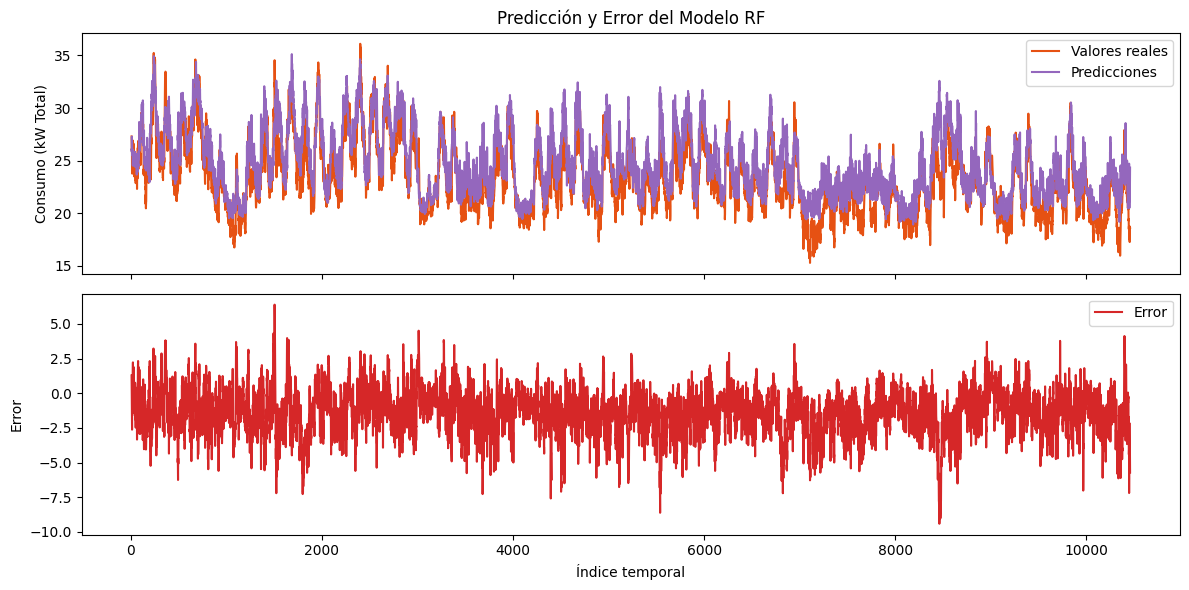

In [ ]:
#resíduo
error = y_test - y_pred

#figura
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)  

#gráfico de valores reales vs predicciones 
ax1.plot(test_transformado.index, y_test, label='Valores reales', color='#E65113')
ax1.plot(test_transformado.index, y_pred, label='Predicciones', color="tab:purple")
ax1.set_ylabel('Consumo (kW Total)')
ax1.set_title('Valores reales del consumo vs Predicción con RF')
ax1.legend(loc="upper right")

#gráfico del error
ax2.plot(test_transformado.index, error, color='tab:red', label='Error')
ax1.set_title('Predicción y Error del Modelo RF')
ax2.set_xlabel('Índice temporal')  
ax2.set_ylabel('Error')
ax2.legend()

plt.tight_layout()

plt.show()

Histograma de los resíduos

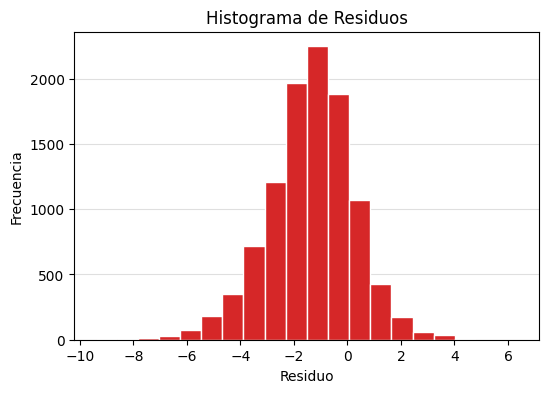

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(error, bins=20, color='tab:red', edgecolor='white')
plt.title('Histograma de Residuos')
plt.xlabel('Residuo')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.4)
plt.gca().set_axisbelow(True)
plt.show()

# MLP

In [ ]:
#normalizamos los datos
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
train_scaled = pd.DataFrame([])
test_scaled = pd.DataFrame([])

train_scaled[cols] = scaler_X.fit_transform(train[cols])
train_scaled[target] = scaler_y.fit_transform(train[[target]])
test_scaled[cols] = scaler_X.transform(test[cols])
test_scaled[target] = scaler_y.transform(test[[target]])

In [ ]:
#función para crear las secuencias (ventanas de tiempo)
def crear_ventanas(data, features, target, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[features].iloc[i - n_steps:i].values)
        y.append(data[target].iloc[i])
    return np.array(X), np.array(y)

#tamaño de la ventana = 6 (1 hora)
n_steps = 6
X_train_val, y_train_val = crear_ventanas(train_scaled, cols, target, n_steps)
X_test, y_test = crear_ventanas(test_scaled, cols, target, n_steps)

split_val = int(len(X_train_val) * 0.8)  # 80% para entrenamiento, 20% para validación
X_train, X_val = X_train_val[:split_val], X_train_val[split_val:]
y_train, y_val = y_train_val[:split_val], y_train_val[split_val:]

In [ ]:
#para reproducirlo
tf.config.experimental.enable_op_determinism()

#función para construir el modelo
def crear_modelo_mlp(params, X_train, y_train, X_val, y_val, semilla):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Flatten())  #aplanar las ventanas
    model.add(Dense(params["n_units"], activation='relu',
                    kernel_initializer=initializers.GlorotUniform(seed=semilla),
                    bias_initializer=initializers.Zeros()))
    dropout=0
    for _ in range(params["n_layers"] - 1):
      if params["n_layers"] == 2:
        model.add(Dropout(params["dropout_rate"], seed=semilla))
        dropout+=1
      model.add(Dense(params["n_units"], activation='relu',
                      kernel_initializer=initializers.GlorotUniform(seed=semilla),
                      bias_initializer=initializers.Zeros()))
      if dropout == 0:
        model.add(Dropout(params["dropout_rate"], seed=semilla))
        dropout+=1

    model.add(Dense(1, activation='linear',
                kernel_initializer=initializers.GlorotUniform(seed=semilla),
                bias_initializer=initializers.Zeros()))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params["learning_rate"]), loss='mean_squared_error', metrics=['mean_squared_error'])

    #EarlyStopping para detener el entrenamiento si la validación no mejora en 10 épocas
    early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        batch_size=params["batch_size"],
                        epochs=params["epochs"],
                        callbacks=[early_stop],
                        verbose=0)

    val_loss = min(history.history["val_loss"])  #obtener la mejor pérdida en validación
    return model, val_loss


#espacio de búsqueda para optimización de hiperparámetros
search_space = {
    "n_units": np.arange(32, 161, 32),  # de 32 a 160
    "n_layers": [1, 2, 3],
    "dropout_rate": np.arange(0.0, 0.31, 0.05),  # de 0.0 a 0.3
    "learning_rate": [0.001, 0.01, 0.1],
    "batch_size": np.arange(32, 129, 32),  # de 16 a 112
    "epochs": [20, 40, 60]  #máximo de épocas
}

#función de RandomSearch
def random_search(search_space, X_train, y_train, X_val, y_val, iterations=10):
    best_model = None
    best_score = float("inf")  #minimizar la pérdida
    best_params = None

    for i in range(iterations):
        np.random.seed(semilla + i)  #para la reproducibilidad

        #selección aleatoria de hiperparámetros
        params = {
            "n_units": int(np.random.choice(search_space["n_units"])),
            "n_layers": int(np.random.choice(search_space["n_layers"])),
            "dropout_rate": round(np.random.choice(search_space["dropout_rate"]),2),
            "learning_rate": round(np.random.choice(search_space["learning_rate"]),4),
            "batch_size": int(np.random.choice(search_space["batch_size"])),
            "epochs": int(np.random.choice(search_space["epochs"]))
        }

        print(f"Iteración {i+1}/{iterations} con parámetros: {params}")

        model, val_loss = crear_modelo_mlp(params, X_train, y_train, X_val, y_val, semilla+i)
        print(f"Loss: {val_loss:.5f}\n ")

        if val_loss < best_score:
            best_score = val_loss
            best_model = model
            best_params = params

    print("\nMejores parámetros encontrados:", best_params, f"\nMSE: {best_score:.5f}")
    return best_model, best_params

best_model_mlp, best_params_mlp = random_search(search_space, X_train, y_train, X_val, y_val, iterations=50)
joblib.dump(best_model_mlp, 'best_model_mlp.joblib')

Iteración 1/50 con parámetros: {'n_units': 128, 'n_layers': 1, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 20}
Loss: 0.00108
 
Iteración 2/50 con parámetros: {'n_units': 160, 'n_layers': 1, 'dropout_rate': 0.05, 'learning_rate': 0.01, 'batch_size': 96, 'epochs': 20}
Loss: 0.00115
 
Iteración 3/50 con parámetros: {'n_units': 160, 'n_layers': 2, 'dropout_rate': 0.25, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 60}
Loss: 0.00150
 
Iteración 4/50 con parámetros: {'n_units': 128, 'n_layers': 3, 'dropout_rate': 0.15, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 40}
Loss: 0.00095
 
Iteración 5/50 con parámetros: {'n_units': 32, 'n_layers': 1, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 40}
Loss: 0.00128
 
Iteración 6/50 con parámetros: {'n_units': 32, 'n_layers': 1, 'dropout_rate': 0.15, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 20}
Loss: 0.00120
 
Iteración 7/50 con parámetros: {'n_units': 32, 'n_layers': 2, 'd

['best_model_mlp.joblib']

Ahora realizamos Grid Search para buscar todvía mejores hiperparámetros cerca de los encontrados mediante Random Search.

In [ ]:
#espacio de búsqueda
search_space = {
    'n_layers': [3],
    'n_units': [80, 96, 112],  #probamos con valores cercanos a 96
    'dropout_rate': [0.05, 0.1, 0.15],  #valores cercanos a 0.1
    'learning_rate': [0.0005, 0.001, 0.0015],  #valores cercanos a 0.001
    'batch_size': [32],
    'epochs': [40]}

#función grid search
def grid_search(search_space, X_train, y_train, X_val, y_val):
    best_model = None
    best_score = float('inf')  #para minimizar la pérdida
    best_params = None

    total_combinations = len(list(ParameterGrid(search_space)))
    for i, params in enumerate(ParameterGrid(search_space), 1):
        #restablecer la semilla, sino no es reproducible
        np.random.seed(semilla + i)

        print(f"Iteración {i}/{total_combinations} con parámetros: {params}")

        #modelo
        model, val_loss = crear_modelo_mlp(params, X_train, y_train, X_val, y_val, semilla+i)
        print(f"Loss: {val_loss:.5f}\n ")

        #guardar mejor modelo
        if val_loss < best_score:
            best_score = val_loss
            best_model = model
            best_params = params

    print("\nMejores parámetros encontrados:", best_params, f"\nMSE: {best_score:.5f}")
    return best_model, best_params

best_model_mlp2, best_params_mlp2 = grid_search(search_space, X_train, y_train, X_val, y_val)
joblib.dump(best_model_mlp2, 'best_model_mlp2.joblib')

#probamos el mejor modelo con los datos de test
test_loss, test_mae = best_model_mlp2.evaluate(X_test, y_test, verbose=0)
print(f"\nDesempeño en Test -> Loss: {test_loss:.4f}")



Iteración 1/27 con parámetros: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 40, 'learning_rate': 0.0005, 'n_layers': 3, 'n_units': 80}
Loss: 0.00107
 
Iteración 2/27 con parámetros: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 40, 'learning_rate': 0.0005, 'n_layers': 3, 'n_units': 96}
Loss: 0.00098
 
Iteración 3/27 con parámetros: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 40, 'learning_rate': 0.0005, 'n_layers': 3, 'n_units': 112}
Loss: 0.00100
 
Iteración 4/27 con parámetros: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 40, 'learning_rate': 0.001, 'n_layers': 3, 'n_units': 80}
Loss: 0.00096
 
Iteración 5/27 con parámetros: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 40, 'learning_rate': 0.001, 'n_layers': 3, 'n_units': 96}
Loss: 0.00100
 
Iteración 6/27 con parámetros: {'batch_size': 32, 'dropout_rate': 0.05, 'epochs': 40, 'learning_rate': 0.001, 'n_layers': 3, 'n_units': 112}
Loss: 0.00097
 
Iteración 7/27 con parámetros: {'batch_size': 32, 'dropout_

327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


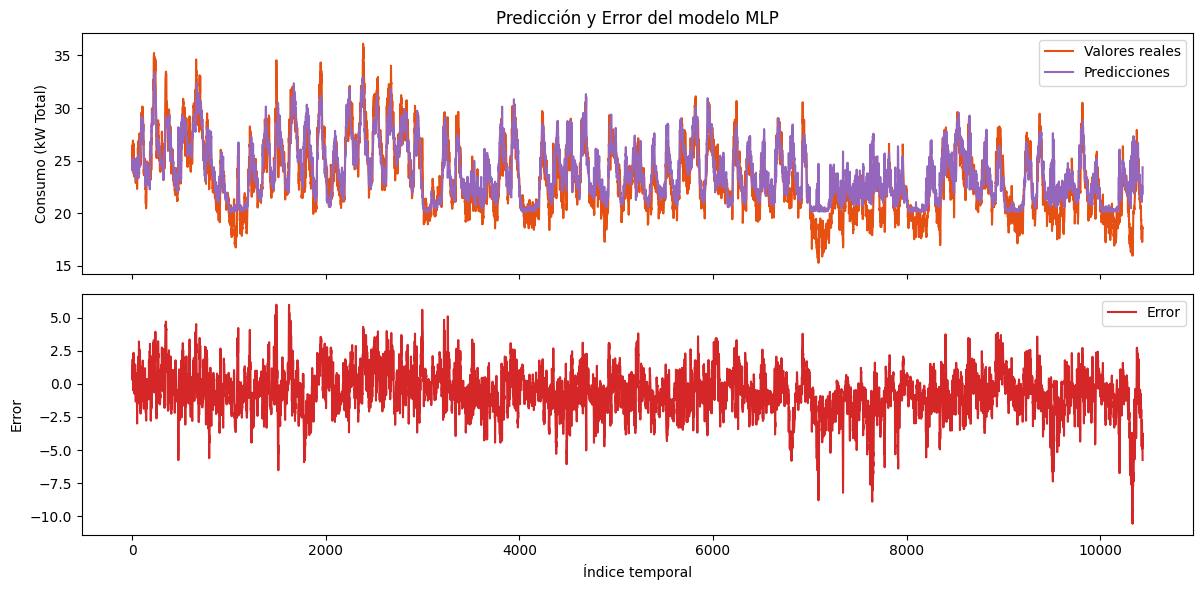

In [ ]:
#predicciones
y_pred = best_model_mlp2.predict(X_test)

#invertimos la normalización
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

#resíduos
error = y_test_inv - y_pred_inv

#figura
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)  

#graficamos valores reales vs las predicciones en el primer subplot
ax1.plot( y_test_inv, label='Valores reales', color='#E65113')
ax1.plot( y_pred_inv, label='Predicciones', color="tab:purple")
ax1.set_ylabel('Consumo (kW Total)')
ax1.set_title('Valores reales del consumo vs Predicción con MLP')
ax1.legend(loc='upper right')

#graficamos el error 
ax2.plot( error, color='tab:red', label='Error')
ax1.set_title('Predicción y Error del modelo MLP')
ax2.set_xlabel('Índice temporal')  
ax2.set_ylabel('Error')
ax2.legend()

plt.tight_layout()

plt.show()

Histograma

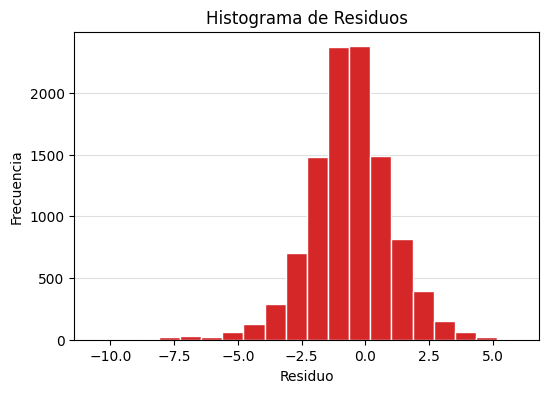

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(error, bins=20, color='tab:red', edgecolor='white')
plt.title('Histograma de Residuos')
plt.xlabel('Residuo')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.4)
plt.gca().set_axisbelow(True)
plt.show()

In [ ]:
mse = mean_squared_error(y_test_inv, y_pred_inv)

mse_sin = mean_squared_error(y_test, y_pred)

mae = mean_absolute_error(y_test_inv, y_pred_inv)

r2 = r2_score(y_test_inv, y_pred_inv)

R = raiz_fraccion_absoluta_varianza(y_test_inv, y_pred_inv)

print('MSE sin transformar', mse_sin)
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")
print(f"R: {R}")

MSE sin transformar 0.0008188747910646441
MSE: 3.097318457743196
MAE: 1.3316064391611648
R2: 0.7041438008488115
R: 0.7140845624601155


# LSTM 


Tenemos X_train, y_train, X_val, y_val, X_test e y_test calculados de antes (en elmodelo MLP). Por lo que construimos el modelo directamente y seleccionamos el mejor tras realizar random search.

In [ ]:
#función para crear el modelo
def crear_modelo_lstm(params, X_train, y_train, X_val, y_val, semilla):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=params["n_units"], activation="tanh", return_sequences=(params["n_layers"] > 1)))

    n_layers = params["n_layers"]
    dropout=0
    for _ in range(n_layers - 1):
      if n_layers == 2:
        model.add(Dropout(params["dropout_rate"], seed=semilla))
        dropout=1
      model.add(LSTM(params["n_units"], activation='tanh', return_sequences=(dropout==0)))
      if dropout == 0:
          model.add(Dropout(params["dropout_rate"], seed=semilla))
          dropout=1
    model.add(Dense(1))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params["learning_rate"]),
                  loss="mse",
                  metrics=["mse"])

    #EarlyStopping para detener el entrenamiento si la validación no mejora en 10 épocas
    early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        batch_size=params["batch_size"],
                        epochs=params["epochs"],
                        callbacks=[early_stop],
                        verbose=0)

    val_loss = min(history.history["val_loss"])  #obtener la mejor pérdida en validación
    return model, val_loss

#función de RandomSearch
def random_search(search_space, X_train, y_train, X_val, y_val, iterations=10):
    best_model = None
    best_score = float("inf")  #minimizar la pérdida
    best_params = None

    for i in range(iterations):
        np.random.seed(semilla + i)  #para la reproducibilidad

        #selección aleatoria de hiperparámetros
        params = {
            "n_units": int(np.random.choice(search_space["n_units"])),
            "n_layers": int(np.random.choice(search_space["n_layers"])),
            "dropout_rate": round(np.random.choice(search_space["dropout_rate"]),2),
            "learning_rate": round(np.random.choice(search_space["learning_rate"]),4),
            "batch_size": int(np.random.choice(search_space["batch_size"])),
            "epochs": int(np.random.choice(search_space["epochs"]))
        }

        print(f"Iteración {i+1}/{iterations} con parámetros: {params}")

        model, val_loss = crear_modelo_lstm(params, X_train, y_train, X_val, y_val, semilla+i)
        print(f"Loss: {val_loss:.5f}\n ")

        if val_loss < best_score:
            best_score = val_loss
            best_model = model
            best_params = params

    print("\nMejores parámetros encontrados:", best_params, f"\nMSE: {best_score:.5f}")
    return best_model, best_params

#espacio de búsqueda para optimización de hiperparámetros
search_space = {
    "n_units": np.arange(32, 161, 32),  # de 32 a 160
    "n_layers": [1, 2, 3],
    "dropout_rate": np.arange(0.0, 0.31, 0.05),  # de 0.0 a 0.3
    "learning_rate": [0.001, 0.01, 0.1],
    "batch_size": np.arange(32, 129, 32),  # de 16 a 112
    "epochs": [20, 40, 60]  #máximo de épocas
}

#ejecutamos
best_model, best_params = random_search(search_space, X_train, y_train, X_val, y_val, iterations=50)
joblib.dump(best_model, 'best_model_lstm.joblib')

#evaluamos el mejor modelo 
test_loss, test_mae = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\nDesempeño en Test -> Loss: {test_loss:.4f}")

Iteración 1/50 con parámetros: {'n_units': 128, 'n_layers': 1, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 20}
Loss: 0.00118
 
Iteración 2/50 con parámetros: {'n_units': 160, 'n_layers': 1, 'dropout_rate': 0.05, 'learning_rate': 0.01, 'batch_size': 96, 'epochs': 20}
Loss: 0.00088
 
Iteración 3/50 con parámetros: {'n_units': 160, 'n_layers': 2, 'dropout_rate': 0.25, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 60}
Loss: 0.00101
 
Iteración 4/50 con parámetros: {'n_units': 128, 'n_layers': 3, 'dropout_rate': 0.15, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 40}
Loss: 0.00100
 
Iteración 5/50 con parámetros: {'n_units': 32, 'n_layers': 1, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 40}
Loss: 0.00087
 
Iteración 6/50 con parámetros: {'n_units': 32, 'n_layers': 1, 'dropout_rate': 0.15, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 20}
Loss: 0.00127
 
Iteración 7/50 con parámetros: {'n_units': 32, 'n_layers': 2, 'd

Ahora utilizamos Grid Search para encontrar mejores hiperparámetros cerca de los obtenidos con Random Search.

In [ ]:
#función de RandomSearch
def grid_search(search_space, X_train, y_train, X_val, y_val):
    best_model = None
    best_score = float("inf")  #minimizar la pérdida
    best_params = None

    total_combinations = len(list(ParameterGrid(search_space)))
    for i, params in enumerate(ParameterGrid(search_space), 1):
        np.random.seed(semilla + i)  #para la reproducibilidad

        print(f"Iteración {i}/{total_combinations} con parámetros: {params}")

        model, val_loss = crear_modelo_lstm(params, X_train, y_train, X_val, y_val, semilla+i)
        print(f"Loss: {val_loss:.5f}\n ")

        if val_loss < best_score:
            best_score = val_loss
            best_model = model
            best_params = params

    print("\nMejores parámetros encontrados:", best_params, f"\nMSE: {best_score:.5f}")
    return best_model, best_params

#espacio de búsqueda para optimización de hiperparámetros
search_space = {
    "n_units": [112, 128, 144],
    "n_layers": [3],
    "dropout_rate": [0.15, 0.2, 0.25],  
    "learning_rate": [0.005, 0.01, 0.015],
    "batch_size": [96],
    "epochs": [40]  #máximo de épocas
    }


#ejecutamos grid search
best_model2, best_params2 = grid_search(search_space, X_train, y_train, X_val, y_val)
joblib.dump(best_model2, 'best_model_lstm.joblib')

#evaluamos el mejor modelo
test_loss2, test_mae2 = best_model2.evaluate(X_test, y_test, verbose=0)
print(f"\nDesempeño en Test -> Loss: {test_loss2:.4f}")

Iteración 1/27 con parámetros: {'batch_size': 96, 'dropout_rate': 0.15, 'epochs': 40, 'learning_rate': 0.005, 'n_layers': 3, 'n_units': 112}
Loss: 0.00085
 
Iteración 2/27 con parámetros: {'batch_size': 96, 'dropout_rate': 0.15, 'epochs': 40, 'learning_rate': 0.005, 'n_layers': 3, 'n_units': 128}
Loss: 0.00086
 
Iteración 3/27 con parámetros: {'batch_size': 96, 'dropout_rate': 0.15, 'epochs': 40, 'learning_rate': 0.005, 'n_layers': 3, 'n_units': 144}
Loss: 0.00085
 
Iteración 4/27 con parámetros: {'batch_size': 96, 'dropout_rate': 0.15, 'epochs': 40, 'learning_rate': 0.01, 'n_layers': 3, 'n_units': 112}
Loss: 0.00093
 
Iteración 5/27 con parámetros: {'batch_size': 96, 'dropout_rate': 0.15, 'epochs': 40, 'learning_rate': 0.01, 'n_layers': 3, 'n_units': 128}
Loss: 0.00087
 
Iteración 6/27 con parámetros: {'batch_size': 96, 'dropout_rate': 0.15, 'epochs': 40, 'learning_rate': 0.01, 'n_layers': 3, 'n_units': 144}
Loss: 0.00086
 
Iteración 7/27 con parámetros: {'batch_size': 96, 'dropout_ra

Los resultados en la validación son peores, por lo que nos quedamos con el modelo obtenido en grid search.

327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


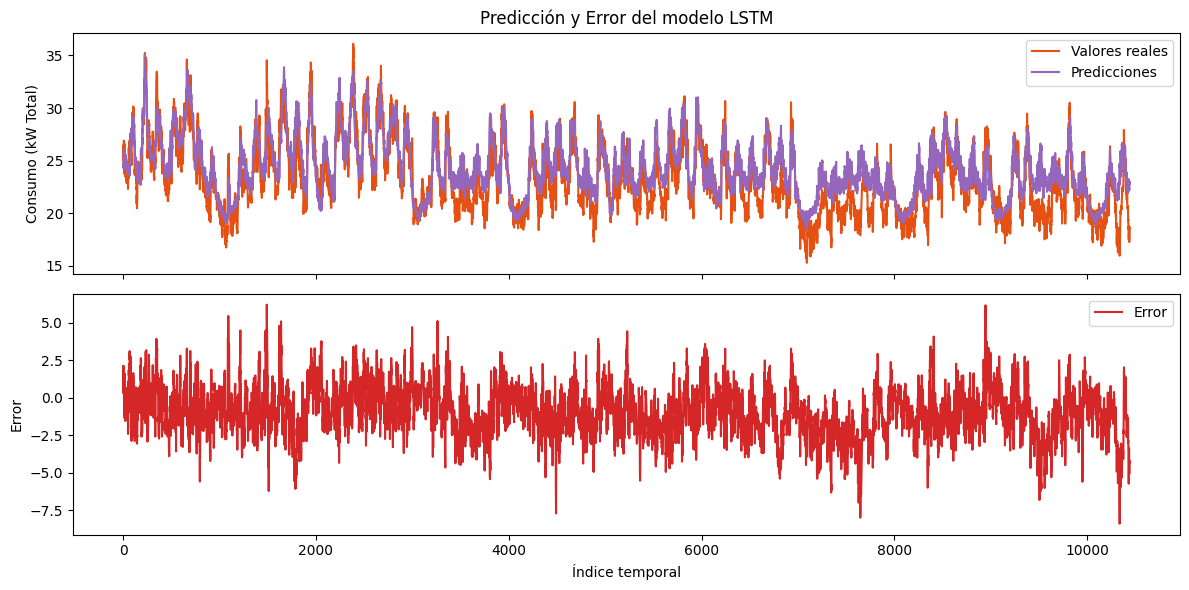

In [ ]:
#realizamos predicciones 
y_pred = best_model.predict(X_test)

#invertimos la normalización 
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

#resíduos
error = y_test_inv - y_pred_inv

#figura
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)  

# graficamos los valores reales vs las predicciones
ax1.plot( y_test_inv, label='Valores reales', color='#E65113')
ax1.plot( y_pred_inv, label='Predicciones', color="tab:purple")
ax1.set_ylabel('Consumo (kW Total)')
ax1.set_title('Valores reales del consumo vs Predicción con RF')
ax1.legend(loc='upper right')

#graficamos el error 
ax2.plot( error, color='tab:red', label='Error')
ax1.set_title('Predicción y Error del modelo LSTM')
ax2.set_xlabel('Índice temporal')  
ax2.set_ylabel('Error')
ax2.legend()

plt.tight_layout()

plt.show()

Histograma.

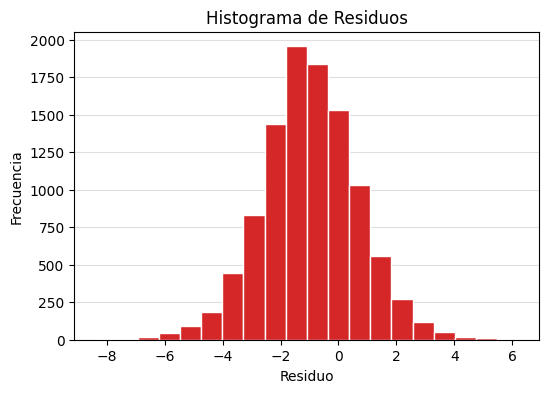

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(error, bins=20, color='tab:red', edgecolor='white')
plt.title('Histograma de Residuos')
plt.xlabel('Residuo')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.4)
plt.gca().set_axisbelow(True)
plt.show()

Calculamos diferentes métricas.

In [ ]:
mse = mean_squared_error(y_test_inv, y_pred_inv)

mse_sin = mean_squared_error(y_test, y_pred)

mae = mean_absolute_error(y_test_inv, y_pred_inv)

r2 = r2_score(y_test_inv, y_pred_inv)

R = raiz_fraccion_absoluta_varianza(y_test_inv, y_pred_inv)

print('MSE sin transformar', mse_sin)
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")
print(f"R: {R}")

MSE sin transformar 0.0009839321109312367
MSE: 3.721632673406113
MAE: 1.53655610862651
R2: 0.6445092384226185
R: 0.7670716159392906
